In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, logging
sys.path.append('./src')
sys.path.append('..')

logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    force=True
)

In [3]:
import torch
from safetensors.torch import load_file

## High-Dimensional Gaussian (HDG) mixtures

In [4]:
from catsbench import BenchmarkHDGConfig, BenchmarkHDG

### Create new benchmark

INFO:catsbench:[Rank 0] Building parameters...
INFO:catsbench:[Rank 0] Sampled means (indices):
[[12.  4.]
 [46. 36.]
 [ 1. 30.]
 [42.  8.]
 [19. 48.]]
INFO:catsbench.benchmarks.hdg:[Rank 0] Sampling validation dataset...


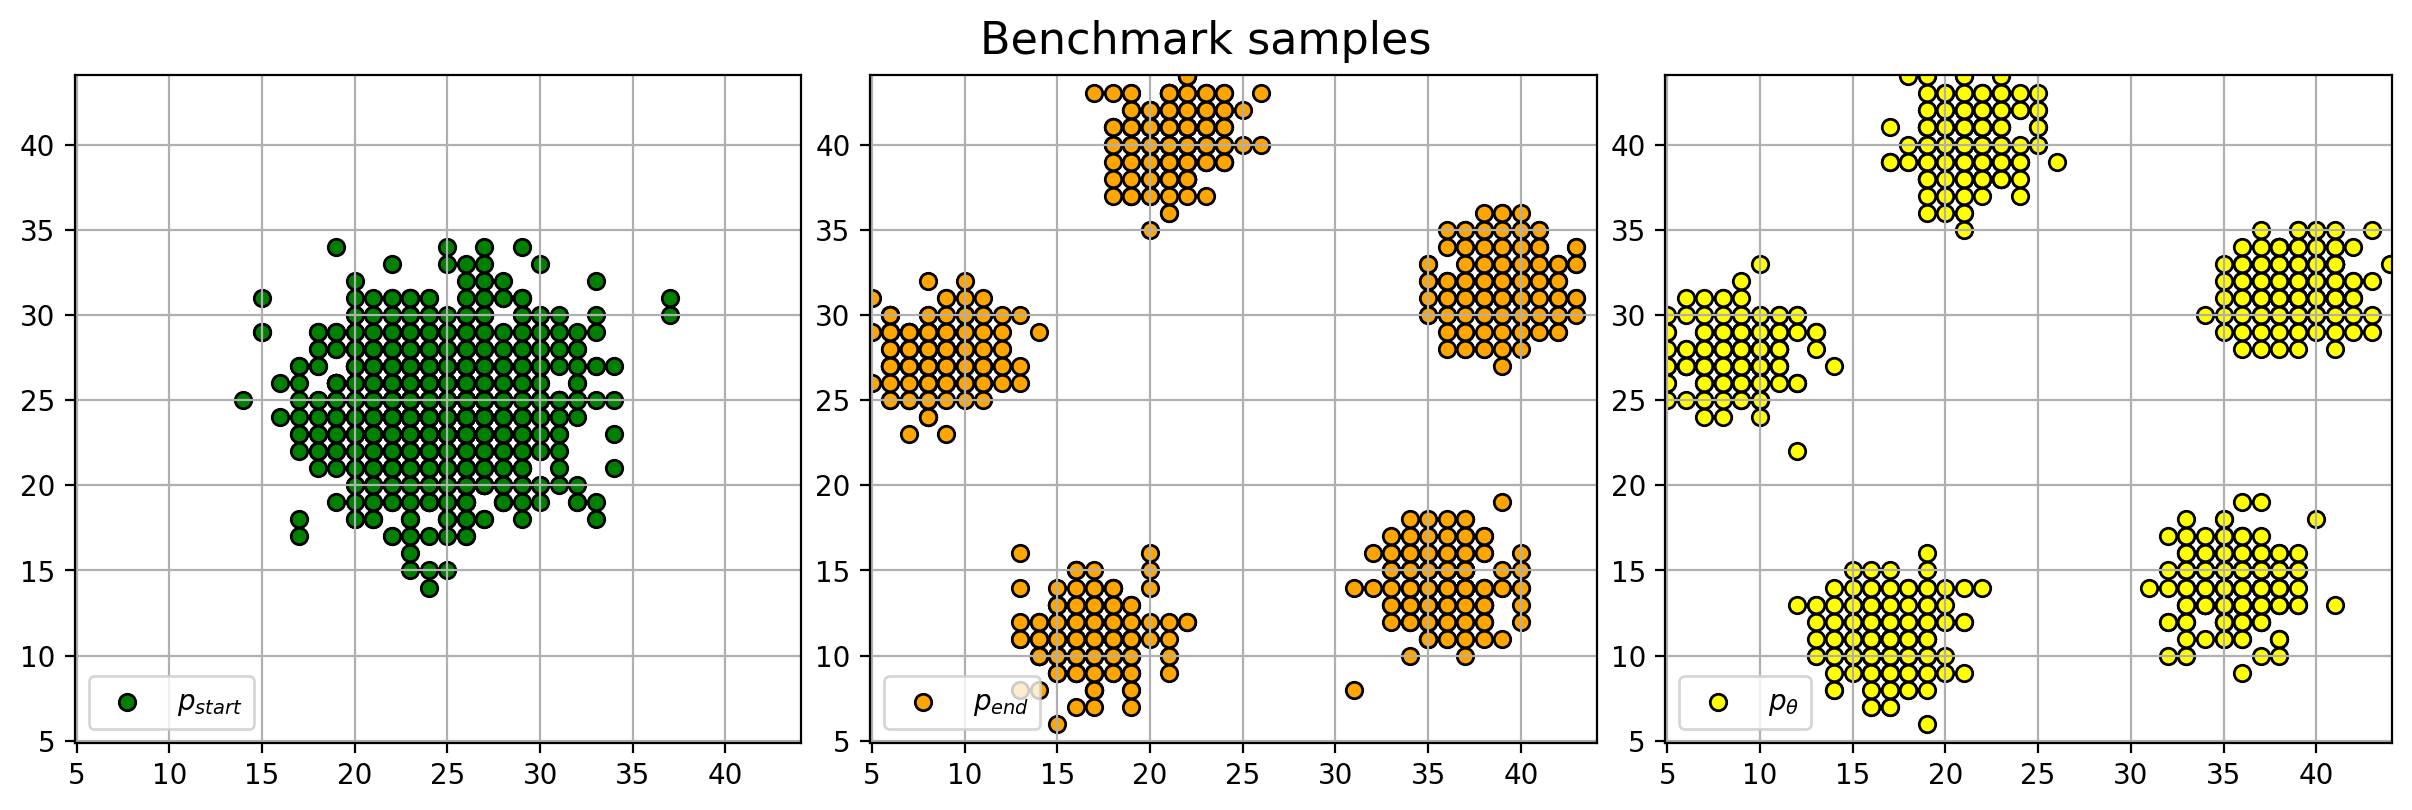

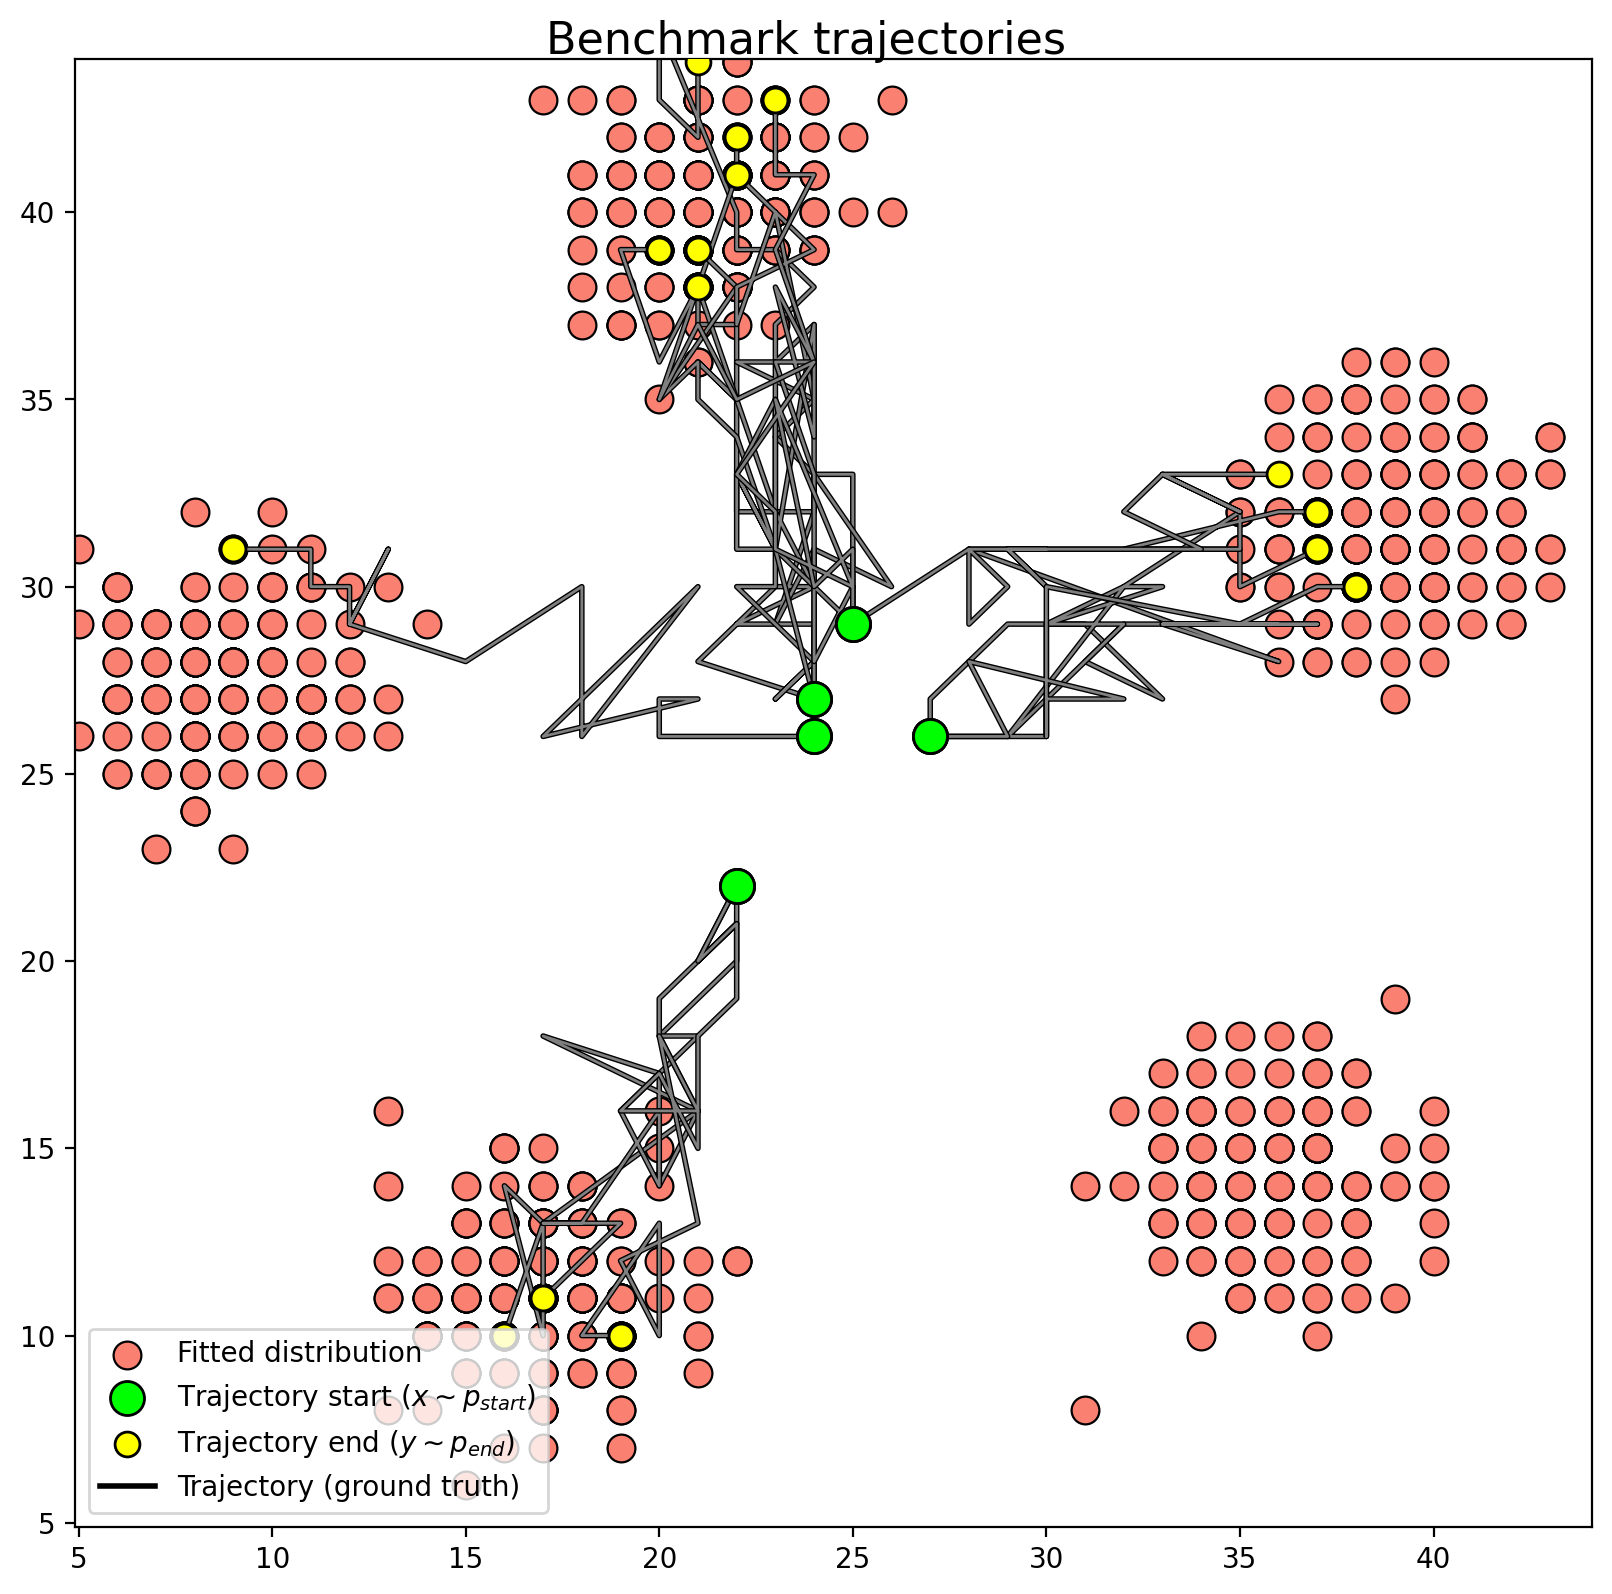

In [5]:
config = BenchmarkHDGConfig(
    dim=2,
    num_potentials=5,
    num_categories=50,
    alpha=0.02,
    num_timesteps=15,
    num_skip_steps=8,
    prior_type='gaussian',
    benchmark_type='gaussian',
    input_distribution='gaussian',
    num_val_samples=20_000,
    reverse=False,
    tau=1.0,
)
bench = BenchmarkHDG(config)
bench.plot(num_samples=1000, num_trajectories=5, num_translations=3)

### Save benchmark

In [6]:
bench.save_pretrained('./hdg_benchmark', bench.name)

TypeError: BenchmarkModelHubMixin.save_pretrained() takes 2 positional arguments but 3 were given

In [ ]:
state_dict = load_file(f'./hdg_benchmark/{bench.name}/model.safetensors')
state_dict.keys()

dict_keys(['input_dataset', 'target_dataset', 'log_alpha', 'log_cp_cores'])

### Load benchmark

It is preferable to load the benchmark class with the parameter `init_benchmark=False`. This skips the sampling of the validation dataset and loads it directly from the checkpoint, which is especially recommended for image and text benchmarks.

INFO:catsbench:[Rank 0] Skipping parameters initialization!
INFO:catsbench:[Rank 0] Initializing prior...
INFO:catsbench.benchmarks.hdg:[Rank 0] Skipping dataset building!
Loading weights from local directory


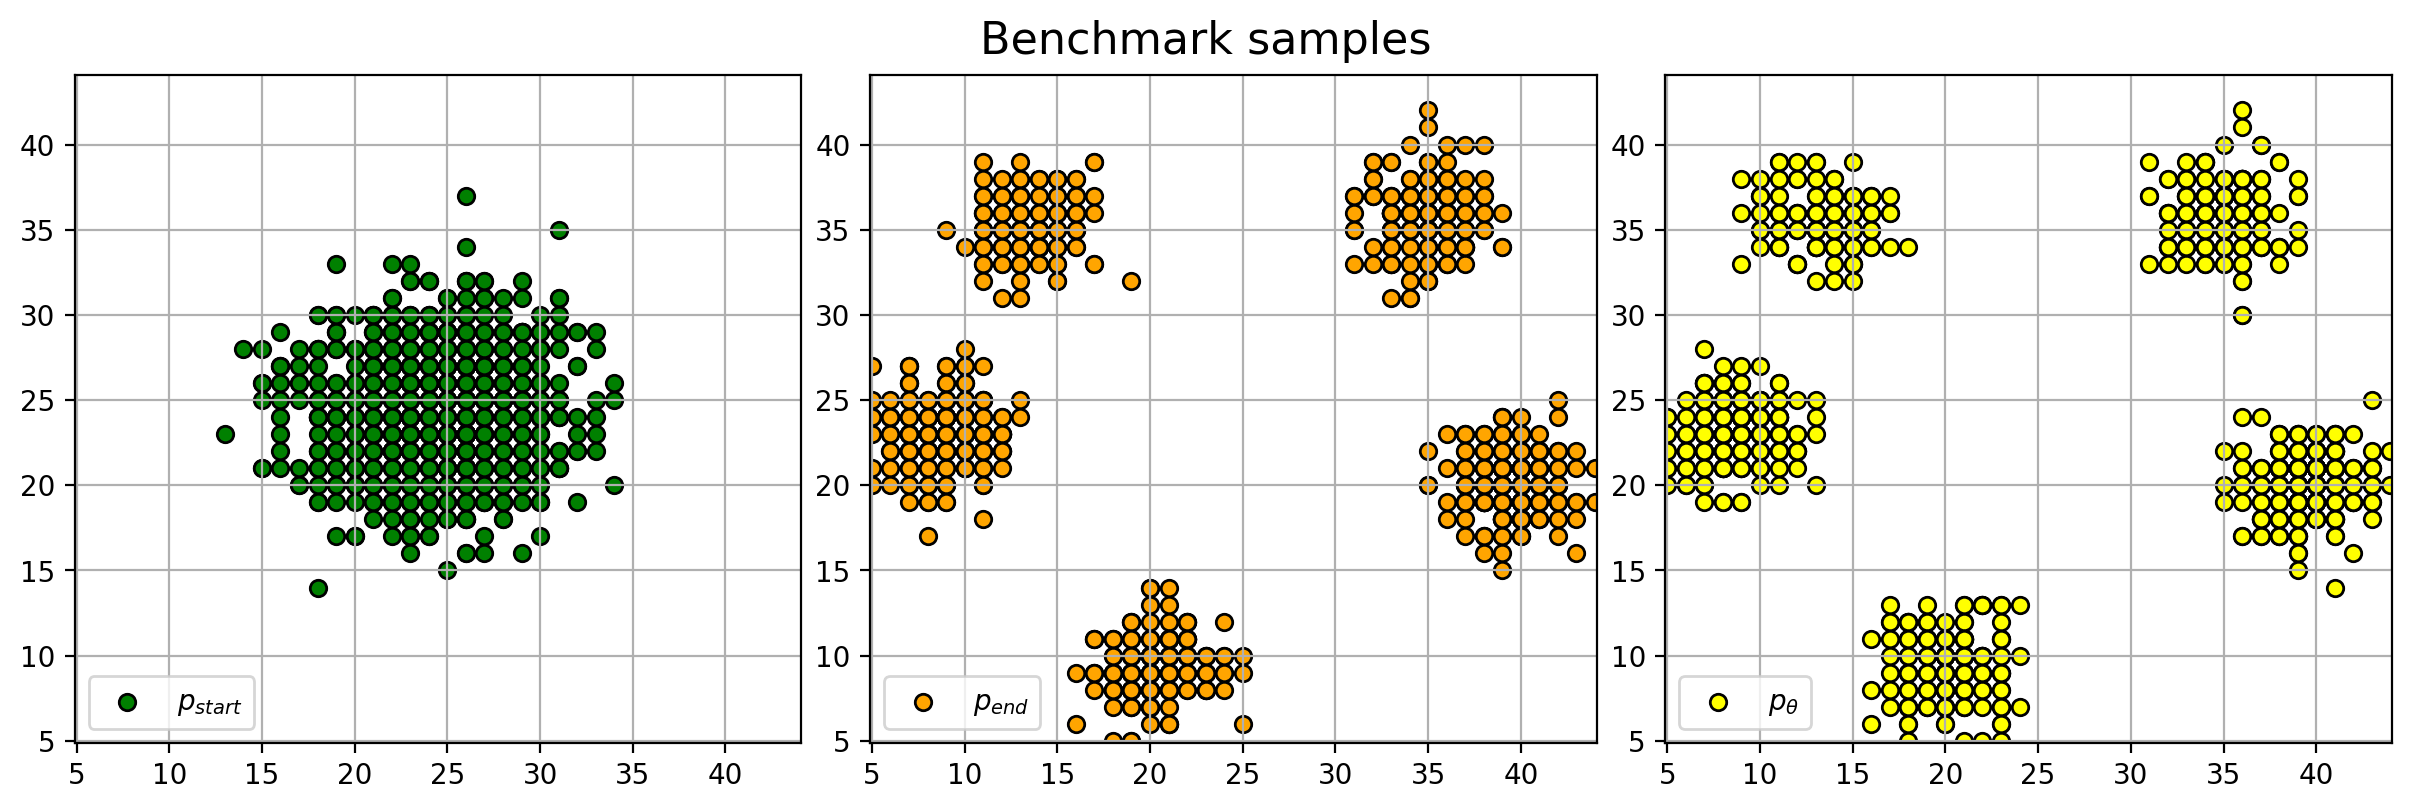

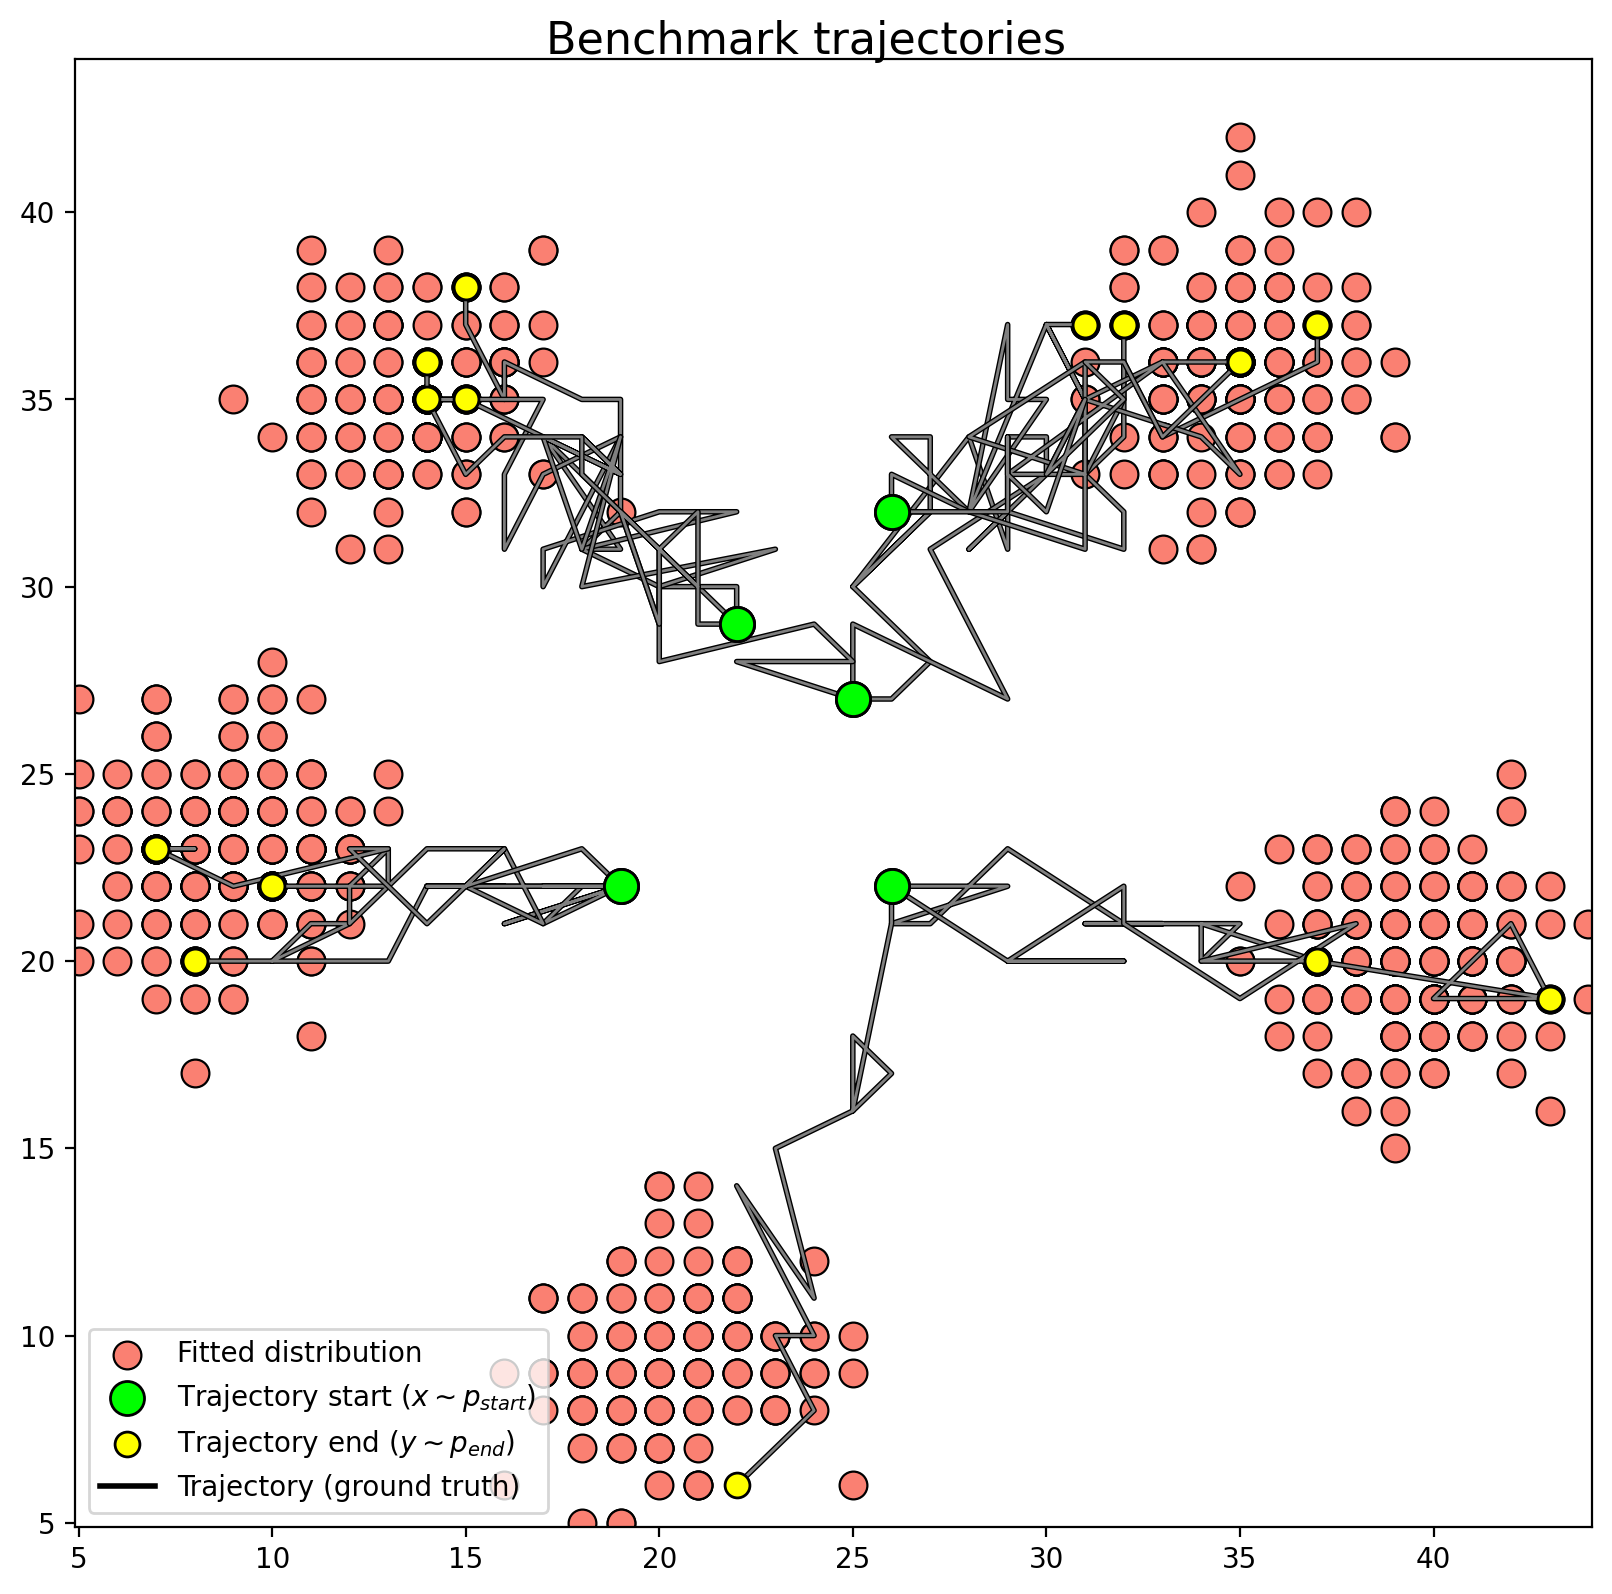

In [14]:
bench_copy = BenchmarkHDG.from_pretrained('./hdg_benchmark', bench.name, init_benchmark=False)
bench_copy.plot(num_samples=1000, num_trajectories=5, num_translations=3)

In [ ]:
assert torch.allclose(bench.log_alpha, bench_copy.log_alpha), \
    'Values of log_alpha do not match after loading from checkpoint!'
assert torch.allclose(bench.log_cp_cores, bench_copy.log_cp_cores), \
    'Values of log_cp_cores do not match after loading from checkpoint!'
assert torch.allclose(bench.input_dataset, bench_copy.input_dataset), \
    'Values of input_dataset do not match after loading from checkpoint!'
assert torch.allclose(bench.target_dataset, bench_copy.target_dataset), \
    'Values of target_dataset do not match after loading from checkpoint!'

### Upload benchmark to HuggigFace

In [ ]:
bench.push_to_hub(
    repo_id='gregkseno/catsbench',
    subfolder=bench.name,
    commit_message=f'Add {bench.name}',
    token=os.getenv('HF_HUB_TOKEN')
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/gregkseno/catsbench/commit/08ce76e5ebd15a62e54690510aa37db52d5c4f79', commit_message='Add hdg_d2_s50_gaussian_a0.02_gaussian', commit_description='', oid='08ce76e5ebd15a62e54690510aa37db52d5c4f79', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gregkseno/catsbench', endpoint='https://huggingface.co', repo_type='model', repo_id='gregkseno/catsbench'), pr_revision=None, pr_num=None)

In [13]:
bench_copy = BenchmarkHDG.from_pretrained(
    'gregkseno/catsbench', 'hdg_d2_s50_gaussian_a0.02_gaussian', init_benchmark=False
)

INFO:catsbench:[Rank 0] Skipping parameters initialization!
INFO:catsbench:[Rank 0] Initializing prior...
INFO:catsbench.benchmarks.hdg:[Rank 0] Skipping dataset building!
